## Project 5: WAM News Prediction of  California's Gubernatorial Election

## Problem Statement:

WAM News is trying to develop an accurate model that predicts the gubernatorial election in California. Using the CCEC Dataset from Harvard University, we would like to build a classification model to accurately classify and predict California’s gubernatorial election preferences. The model will be evaluated based on accuracy, specificity, and recall with the goal of trying to get accuracy above null model.

In [1]:
# !pip install tensorflow

In [82]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline
# sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn import metrics
# keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import Recall
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

## Load Data

In [3]:
# read data
df=pd.read_csv('./data/2018_gov_clean.csv')
df.head()

,Unnamed: 0,dist,gender,age,educ,race,faminc,marstat,newsint,approval_gov,ideo5,voted_gov,voted_gov_num
0,0,19,Female,54,4-Year,White,50k - 60k,Single / Never Married,Most of the time,Strongly Approve,Liberal,[Democrat / Candidate 1],0
1,1,52,Female,28,Some College,White,20k - 30k,Single / Never Married,Most of the time,Strongly Approve,Liberal,[Democrat / Candidate 1],0
2,2,49,Male,86,Post-Grad,White,120k - 150k,Widowed,Most of the time,Strongly Disapprove,Very Conservative,[Republican / Candidate 2],1
3,3,36,Male,80,Some College,White,20k - 30k,Widowed,Most of the time,Strongly Disapprove,Conservative,[Republican / Candidate 2],1
4,4,36,Male,83,4-Year,White,Prefer not to say,Married,Most of the time,Strongly Disapprove,Conservative,[Republican / Candidate 2],1


In [4]:
# df=df.drop(columns=['Unnamed: 0'], inplace=True)

# Modeling

In [5]:
# set up X and y
X = df.drop(columns =['voted_gov', 'voted_gov_num'])
y = df['voted_gov_num']

In [6]:
# dummify X variable
X = pd.get_dummies(X, drop_first=True)

In [7]:
# checkout X shape
X.shape

(3676, 46)

In [8]:
# check if shape of X = y
assert X.shape[0]==y.shape[0]

### 1. Multinomial Naive Bayes

In [9]:
# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [10]:
# instantiate and fit NB
nb = MultinomialNB()
nb.fit(X_train, y_train)

MultinomialNB()

In [11]:
# make predictions 
y_pred = nb.predict(X_test)

# save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

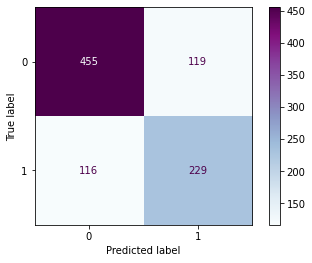

In [12]:
# plot a confusion matrix
plot_confusion_matrix(nb, X_test, y_test, cmap='BuPu', values_format='d');

In [13]:
# sensitivity and accuracy
accu = (tp+tn) / (tp+tn+fp+fn)
recall = tp/(tp+fn)
prec = tp/ (tp+fp)

print('Accuracy:', accu)
print('Recall:', recall)
print('Precision:', prec)

Accuracy: 0.7442872687704026
Recall: 0.663768115942029
Precision: 0.6580459770114943


In [14]:
# accuracy on test vs train data
print('Accuracy on train data:', nb.score(X_train, y_train))
print('Accuracy on test data:', nb.score(X_test, y_test))

Accuracy on train data: 0.7323177366702938
Accuracy on test data: 0.7442872687704026


In [15]:
# classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.79      0.79       574
           1       0.66      0.66      0.66       345

    accuracy                           0.74       919
   macro avg       0.73      0.73      0.73       919
weighted avg       0.74      0.74      0.74       919



Multinomial Naive Bayes has an 74% accuracy, a precision of 66% and a recall of 66%. It improved the null model accuracy of 62%.

### 2. Neural Net Classification - 1 hidden layer & early stopping

In [67]:
# set a random seed
tf.random.set_seed(1234)

In [68]:
# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [69]:
# scale data
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [70]:
# create model with one hidden layer
model_nn1 = Sequential()
model_nn1.add(Dense(32, input_shape=(X_train_sc.shape[1],), activation='relu'))
model_nn1.add(Dense(1, activation='sigmoid'))

In [71]:
model_nn1.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 32)                1504      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 33        
Total params: 1,537
Trainable params: 1,537
Non-trainable params: 0
_________________________________________________________________


In [72]:
# Compile it
model_nn1.compile(loss='bce', optimizer='adam', metrics=['Accuracy', 'Recall', 'Precision'])

In [73]:
# set early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

In [74]:
# fit model
history = model_nn1.fit(
    X_train_sc, y_train, 
    validation_data=(X_test_sc, y_test), 
    epochs=100, 
    callbacks=[early_stop], 
    verbose=2,
    batch_size=32
)

Epoch 1/100
87/87 - 1s - loss: 0.5913 - Accuracy: 0.7051 - recall: 0.6915 - precision: 0.5914 - val_loss: 0.4309 - val_Accuracy: 0.8368 - val_recall: 0.7072 - val_precision: 0.8328
Epoch 2/100
87/87 - 0s - loss: 0.3627 - Accuracy: 0.8836 - recall: 0.7979 - precision: 0.8805 - val_loss: 0.3192 - val_Accuracy: 0.8857 - val_recall: 0.8058 - val_precision: 0.8797
Epoch 3/100
87/87 - 0s - loss: 0.2809 - Accuracy: 0.9061 - recall: 0.8424 - precision: 0.9007 - val_loss: 0.2748 - val_Accuracy: 0.8988 - val_recall: 0.8348 - val_precision: 0.8889
Epoch 4/100
87/87 - 0s - loss: 0.2426 - Accuracy: 0.9148 - recall: 0.8569 - precision: 0.9106 - val_loss: 0.2550 - val_Accuracy: 0.9108 - val_recall: 0.8493 - val_precision: 0.9071
Epoch 5/100
87/87 - 0s - loss: 0.2220 - Accuracy: 0.9166 - recall: 0.8559 - precision: 0.9161 - val_loss: 0.2438 - val_Accuracy: 0.9108 - val_recall: 0.8493 - val_precision: 0.9071
Epoch 6/100
87/87 - 0s - loss: 0.2096 - Accuracy: 0.9217 - recall: 0.8714 - precision: 0.9157 -

In [24]:
# save history into a df
history_df = pd.DataFrame(history.history)
history_df.head()

,loss,Accuracy,recall,precision,val_loss,val_Accuracy,val_recall,val_precision
0,0.591283,0.705114,0.691489,0.591398,0.430915,0.836779,0.707246,0.832765
1,0.362687,0.883569,0.797872,0.880470,0.319198,0.885745,0.805797,0.879747
2,0.280935,0.906057,0.842360,0.900724,0.274756,0.898803,0.834783,0.888889
3,0.242646,0.914762,0.856867,0.910586,0.254992,0.910773,0.849275,0.907121
4,0.222010,0.916576,0.855899,0.916149,0.243796,0.910773,0.849275,0.907121


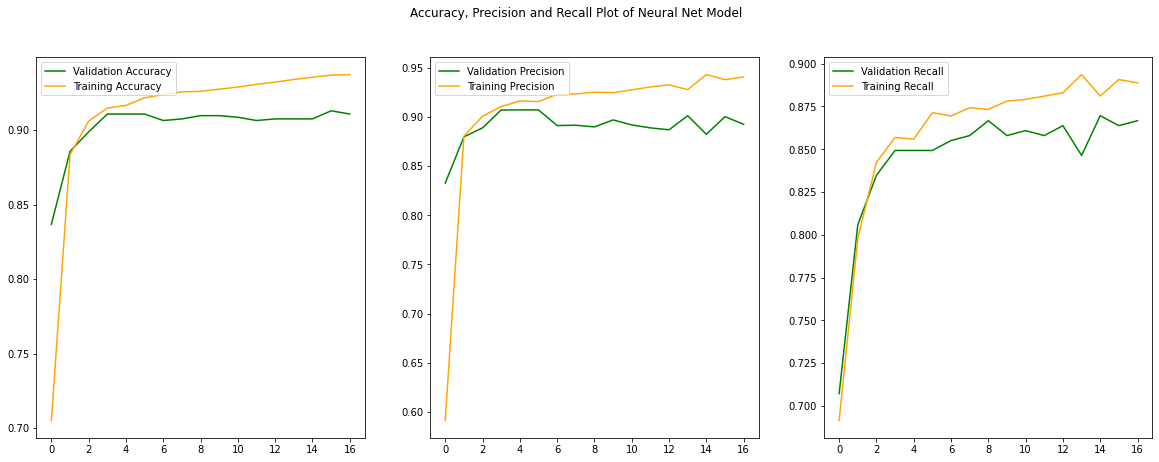

In [76]:
# subplots of accuracy, precision and recall
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols=3, figsize = (20, 7))
fig.suptitle('Accuracy, Precision and Recall Plot of Neural Net Model')

# axis 1
ax1.plot(history_df['val_Accuracy'], label='Validation Accuracy', color='green')
ax1.plot(history_df['Accuracy'], label='Training Accuracy', color='orange')
ax1.legend(loc="upper left")
# axis 2
ax2.plot(history_df['val_precision'], label='Validation Precision', color='green')
ax2.plot(history_df['precision'], label='Training Precision', color='orange')
ax2.legend(loc="upper left")
#axis3
ax3.plot(history_df['val_recall'], label='Validation Recall', color='green')
ax3.plot(history_df['recall'], label='Training Recall', color='orange')
ax3.legend(loc="upper right")

plt.legend();

The plots show that this model with one hidden layer and early stopping is slightly overfit. 

In [27]:
# evaluate model
model_nn1.evaluate(X_test_sc, y_test, verbose=2)

29/29 - 0s - loss: 0.2379 - Accuracy: 0.9108 - recall: 0.8667 - precision: 0.8925


[0.23788246512413025,
 0.9107725620269775,
 0.8666666746139526,
 0.8925372958183289]

In [28]:
# make predictions
y_pred_nn1=model_nn1.predict(X_test_sc)
y_pred_nn1[:10]

array([[0.9983752 ],
       [0.11909774],
       [0.5305984 ],
       [0.08015236],
       [0.04525724],
       [0.0776079 ],
       [0.01472563],
       [0.999033  ],
       [0.03794074],
       [0.00453642]], dtype=float32)

In [29]:
# round predicted values
y_pred_nn1 =y_pred_nn1.round()
y_pred_nn1[:10]

array([[1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.]], dtype=float32)

In [30]:
# confusion matrix using Tensorflow
tf.math.confusion_matrix(
    y_test, y_pred_nn1
)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[538,  36],
       [ 46, 299]], dtype=int32)>

In [31]:
# classification report
print(classification_report(y_test, y_pred_nn1))

              precision    recall  f1-score   support

           0       0.92      0.94      0.93       574
           1       0.89      0.87      0.88       345

    accuracy                           0.91       919
   macro avg       0.91      0.90      0.90       919
weighted avg       0.91      0.91      0.91       919



On test data: 
- accuracy: 0.9108 
- recall: 0.8667 
- precision: 0.8925

On train data:
- accuracy: 0.9373 
- recall: 0.8888 
- precision: 0.9406

This model has an accuracy of 91% which improved the null model accuracy of 62%.  

### Null model

- For classification problems, we build our null model based on the most frequent value in the train data. We would use the shape of X_test to create array which will be predictions from the null model. 

In [32]:
# checkout X_test shape
X_test.shape

(919, 46)

In [33]:
# which one is the most frequent value?
y_train.value_counts(normalize=True)

0    0.624955
1    0.375045
Name: voted_gov_num, dtype: float64

In [34]:
# create an array of the most frequent value with number of rows equal to test data
# (this will be our null model predictions)
y_hat = np.zeros(919)
y_hat[:5]

array([0., 0., 0., 0., 0.])

In [35]:
# classification report for the null model
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.62      1.00      0.77       574
           1       0.00      0.00      0.00       345

    accuracy                           0.62       919
   macro avg       0.31      0.50      0.38       919
weighted avg       0.39      0.62      0.48       919



/Users/mekdeswassie/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mekdeswassie/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mekdeswassie/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Our null model accuracy is 62%.

### 3. Neural Net Classification - 2 hidden layers & dropout

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [78]:
# scale data
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [79]:
model_nn2 = Sequential()

In [83]:
# create model
model_nn2.add(Dense(32, input_shape=(X_train_sc.shape[1],), activation='relu'))
model_nn2.add(Dropout(0.2))
model_nn2.add(Dense(10, activation='relu'))
model_nn2.add(Dropout(0.2))
model_nn2.add(Dense(1, activation='sigmoid'))

In [62]:
# compile model
model_nn2.compile(loss='bce', optimizer ='adam', metrics = ['Accuracy', 'Recall', 'Precision'])

In [66]:
# fit model
history_2 = model_nn2.fit(
    X_train_sc,
    y_train,
    validation_data=(X_test_sc, y_test),
    epochs=100,
    verbose=0
)

In [64]:
# save history into a df
history_2_df = pd.DataFrame(history_2.history)
history_2_df.head()

,loss,Accuracy,recall,precision,val_loss,val_Accuracy,val_recall,val_precision
0,0.626487,0.648894,0.625725,0.526873,0.505197,0.831338,0.684058,0.836879
1,0.439801,0.822996,0.726306,0.785565,0.335098,0.872688,0.762319,0.882550
2,0.326026,0.879217,0.806576,0.862461,0.279230,0.887922,0.794203,0.895425
3,0.281677,0.889735,0.823017,0.875514,0.257743,0.898803,0.811594,0.909091
4,0.261898,0.903156,0.844294,0.891726,0.247071,0.902067,0.826087,0.904762


In [43]:
history_2_df['val_Accuracy'][5:]

5     0.903156
6     0.906420
7     0.900979
8     0.898803
9     0.904244
        ...   
95    0.904244
96    0.907508
97    0.903156
98    0.906420
99    0.908596
Name: val_Accuracy, Length: 95, dtype: float64

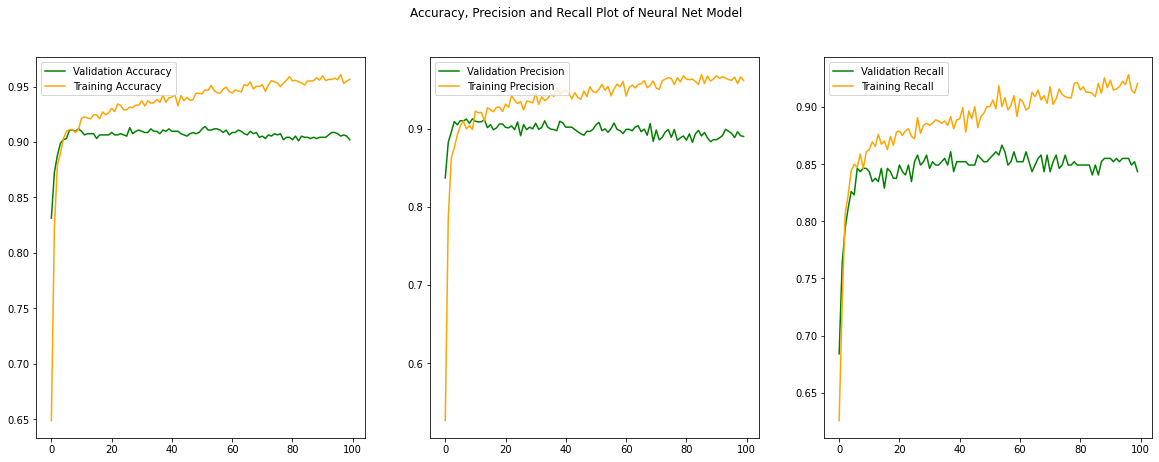

In [112]:
# subplots of accuracy, precision and recall
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols=3, figsize = (20, 7))
fig.suptitle('Accuracy, Precision and Recall Plot of Neural Net Model')

# axis 1 - accuracy
ax1.plot(history_2_df["val_Accuracy"], label='Validation Accuracy', color='green')
ax1.plot(history_2_df["Accuracy"], label='Training Accuracy', color='orange')
ax1.legend(loc="upper left")
# axis 2 - precision
ax2.plot(history_2_df['val_precision'], label='Validation Precision', color='green')
ax2.plot(history_2_df['precision'], label='Training Precision', color='orange')
ax2.legend(loc="upper left")
# axis3 - recall
ax3.plot(history_2_df['val_recall'], label='Validation Recall', color='green')
ax3.plot(history_2_df['recall'], label='Training Recall', color='orange')
ax3.legend(loc="upper right")

plt.legend();

In [45]:
# evaluate model
model_nn2.evaluate(X_test_sc, y_test, verbose=2)

29/29 - 0s - loss: 0.3669 - Accuracy: 0.9086 - recall: 0.8667 - precision: 0.8872


[0.3668990731239319,
 0.9085962772369385,
 0.8666666746139526,
 0.8872403502464294]

In [46]:
# make predictions
y_pred_nn2=model_nn2.predict(X_test_sc)
y_pred_nn2[:10]

array([[9.9999696e-01],
       [4.9172853e-05],
       [7.2009778e-01],
       [1.8903431e-01],
       [1.2260991e-01],
       [2.4028391e-02],
       [2.6009828e-02],
       [9.9999857e-01],
       [1.0962973e-05],
       [2.3484896e-09]], dtype=float32)

In [47]:
# round predicted values
y_pred_nn2 =y_pred_nn2.round()
y_pred_nn2[:10]

array([[1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.]], dtype=float32)

In [48]:
# confusion matrix using Tensorflow
tf.math.confusion_matrix(
    y_test, y_pred_nn2
)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[536,  38],
       [ 46, 299]], dtype=int32)>

In [49]:
# classification report
print(classification_report(y_test, y_pred_nn2))

              precision    recall  f1-score   support

           0       0.92      0.93      0.93       574
           1       0.89      0.87      0.88       345

    accuracy                           0.91       919
   macro avg       0.90      0.90      0.90       919
weighted avg       0.91      0.91      0.91       919



### 4. Neural Net Classification - Early stopping & dropout

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [97]:
# scale data
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [98]:
model_nn3 = Sequential()

In [99]:
# create model
model_nn3.add(Dense(64, input_shape=(X_train_sc.shape[1],), activation='relu'))
model_nn3.add(Dropout(0.2))
model_nn3.add(Dense(128, activation='relu'))

model_nn3.add(Dropout(0.2))
model_nn3.add(Dense(32, activation='relu'))

model_nn3.add(Dense(1, activation='sigmoid'))

In [100]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

In [101]:
# compile model
model_nn3.compile(loss='bce', optimizer ='adam', metrics = ['Accuracy', 'Recall', 'Precision'])

In [102]:
# fit model
history_3 = model_nn3.fit(
    X_train_sc,
    y_train,
    validation_data=(X_test_sc, y_test),
    epochs=100,
    callbacks=early_stop,
    verbose=0
)

Epoch 00010: early stopping


In [103]:
# save history into a df
history_3_df = pd.DataFrame(history_3.history)
history_3_df.head()

,loss,Accuracy,recall,precision,val_loss,val_Accuracy,val_recall,val_precision
0,0.481302,0.778382,0.524178,0.819970,0.310182,0.879217,0.805797,0.863354
1,0.277066,0.894088,0.839458,0.873239,0.259717,0.905332,0.843478,0.898148
2,0.234930,0.910047,0.855899,0.899390,0.250881,0.909684,0.837681,0.914557
3,0.219759,0.913674,0.862669,0.902834,0.239388,0.910773,0.843478,0.912226
4,0.205011,0.920566,0.864603,0.918808,0.233520,0.911861,0.846377,0.912500


In [104]:
history_3_df['val_Accuracy'][5:]

5    0.908596
6    0.908596
7    0.907508
8    0.909684
9    0.911861
Name: val_Accuracy, dtype: float64

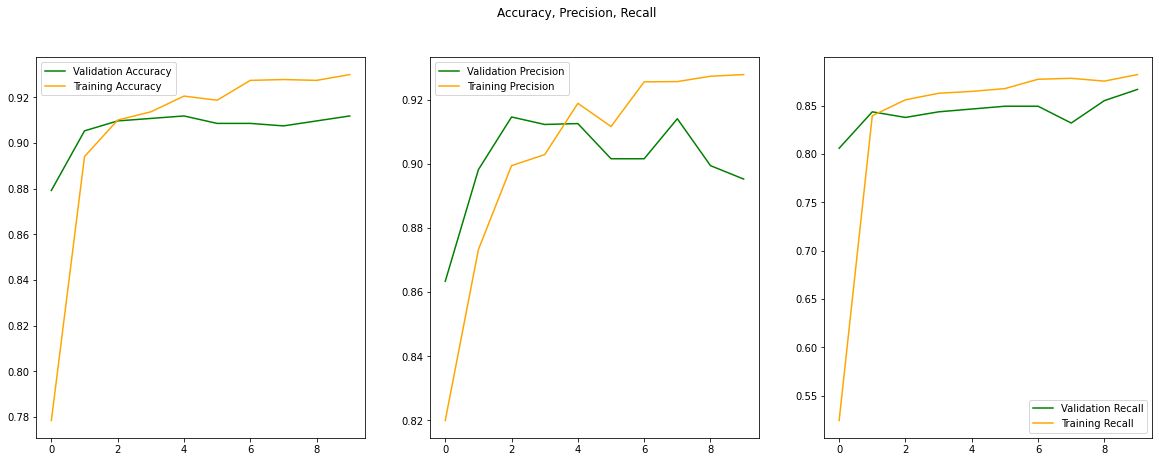

In [111]:
# subplots of accuracy, precision and recall
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols=3, figsize = (20, 7))
fig.suptitle('Accuracy, Precision, Recall')

# axis 1 - accuracy
ax1.plot(history_3_df["val_Accuracy"], label='Validation Accuracy', color='green')
ax1.plot(history_3_df["Accuracy"], label='Training Accuracy', color='orange')
ax1.legend(loc="upper left")
# axis 2 - precision
ax2.plot(history_3_df['val_precision'], label='Validation Precision', color='green')
ax2.plot(history_3_df['precision'], label='Training Precision', color='orange')
ax2.legend(loc="upper left")
# axis3 - recall
ax3.plot(history_3_df['val_recall'], label='Validation Recall', color='green')
ax3.plot(history_3_df['recall'], label='Training Recall', color='orange')
ax3.legend(loc="upper left")

plt.legend();

In [106]:
# evaluate model
model_nn3.evaluate(X_test_sc, y_test, verbose=2)

29/29 - 0s - loss: 0.2478 - Accuracy: 0.9119 - recall: 0.8667 - precision: 0.8952


[0.2477688193321228,
 0.9118607044219971,
 0.8666666746139526,
 0.8952096104621887]

In [107]:
# make predictions
y_pred_nn3=model_nn3.predict(X_test_sc)
y_pred_nn3[:10]

array([[9.9910712e-01],
       [4.6985239e-02],
       [7.8418142e-01],
       [4.5934230e-02],
       [6.5255821e-02],
       [4.9120307e-02],
       [2.4783432e-02],
       [9.9934804e-01],
       [1.7729998e-03],
       [5.0511956e-04]], dtype=float32)

In [108]:
# round predicted values
y_pred_nn3 =y_pred_nn3.round()
y_pred_nn3[:10]

array([[1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.]], dtype=float32)

In [109]:
# confusion matrix using Tensorflow
tf.math.confusion_matrix(
    y_test, y_pred_nn3
)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[539,  35],
       [ 46, 299]], dtype=int32)>

In [110]:
# classification report
print(classification_report(y_test, y_pred_nn3))

              precision    recall  f1-score   support

           0       0.92      0.94      0.93       574
           1       0.90      0.87      0.88       345

    accuracy                           0.91       919
   macro avg       0.91      0.90      0.91       919
weighted avg       0.91      0.91      0.91       919



### GridSearch with nn

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [51]:
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [52]:
# Add an arugment of number of layers to the function (and loop through it) 
def model_fn_deep(hidden_neurons=32, hidden_layers=5, dropout=0.5):
  model = Sequential()
  for layer in range(hidden_layers):
    if layer == 0:
      model.add(Dense(hidden_neurons, input_shape=(46,), activation='relu'))
      model.add(Dropout(dropout))
    else:
      model.add(Dense(hidden_neurons, activation='relu'))
      model.add(Dropout(dropout))

  model.add(Dense(1, activation='sigmoid'))

  model.compile(loss='bce', optimizer='adam', metrics =['Recall', 'Precision'])

  return model

nn_deep = KerasClassifier(build_fn=model_fn_deep, batch_size=32, verbose=2)

In [53]:
nn_params_deep = {
    'hidden_neurons': [32, 64],
    'hidden_layers': [2, 3],
    'dropout': [0.1, 0.2, 0.5],
    'epochs': [10, 20]
}

gs_deep = GridSearchCV(nn_deep, param_grid=nn_params_deep, cv=3, n_jobs=-1)
gs_deep.fit(X_train_sc, y_train)
print(gs_deep.best_params_)
gs_deep.best_score_

/Users/mekdeswassie/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Epoch 1/10
87/87 - 1s - loss: 0.5258 - recall: 0.5641 - precision: 0.7040
Epoch 2/10
87/87 - 0s - loss: 0.3370 - recall: 0.7859 - precision: 0.8428
Epoch 3/10
87/87 - 0s - loss: 0.2678 - recall: 0.8467 - precision: 0.8676
Epoch 4/10
87/87 - 0s - loss: 0.2415 - recall: 0.8602 - precision: 0.8858
Epoch 5/10
87/87 - 0s - loss: 0.2262 - recall: 0.8544 - precision: 0.8977
Epoch 6/10
87/87 - 0s - loss: 0.2088 - recall: 0.8640 - precision: 0.9051
Epoch 7/10
87/87 - 0s - loss: 0.2062 - recall: 0.8717 - precision: 0.9150
Epoch 8/10
87/87 - 0s - loss: 0.2002 - recall: 0.8795 - precision: 0.9102
Epoch 9/10
87/87 - 0s - loss: 0.1988 - recall: 0.8737 - precision: 0.9142
Epoch 10/10
87/87 - 0s - loss: 0.1858 - recall: 0.8910 - precision: 0.9176
{'dropout': 0.1, 'epochs': 10, 'hidden_layers': 2, 'hidden_neurons': 32}


nan

In [54]:
# Make predictions 
preds_deep = gs_deep.predict(X_test_sc)

In [55]:
# confusion matrix using Tensorflow
tf.math.confusion_matrix(
    y_test, preds_deep
)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[544,  33],
       [ 46, 296]], dtype=int32)>

In [56]:
# classification report
print(classification_report(y_test, preds_deep))

              precision    recall  f1-score   support

           0       0.92      0.94      0.93       577
           1       0.90      0.87      0.88       342

    accuracy                           0.91       919
   macro avg       0.91      0.90      0.91       919
weighted avg       0.91      0.91      0.91       919

